In [1]:
from __future__ import print_function, division
import os, bz2, json, time
from datetime import timedelta

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Exploring ACTIVE dataset

In [2]:
with bz2.BZ2File('../data/active-dataset.json.bz2') as f:
    dataset = json.loads(f.readline())
print(len(dataset))
attributes = ["YoutubeID","numTweet","numShare","numSubscriber","watchTime","dailyViewcount",\
              "description","title","channelId","channelTitle","category","uploadDate","duration",\
              "definition","dimension","caption","regionRestriction.blocked",\
              "regionRestriction.allowed","topicIds","relevantTopicIds","totalShare",\
              "totalViewcount","totalTweet","dailyTweets"]

14041


In [3]:
# example video 00-6OyXVA0M
example_ind = 0
for att in attributes:
    if type(dataset[example_ind][att]) is list:
        print(att,": length",len(dataset[example_ind][att]))
    else:
        print(att,":",dataset[example_ind][att]) 

YoutubeID : 00-6OyXVA0M
numTweet : length 5010
numShare : length 130
numSubscriber : length 130
watchTime : length 130
dailyViewcount : length 130
description : Bill's response to Victoria Osteen's congregational message.
The Osteen video was already out before I did the added clip of Bill Cosby.
title : Bill Cosby responds to Victoria Osteen
channelId : UCpzGw-b-rEPjRs2LT0ZVHTQ
channelTitle : Bryant Harris
category : Entertainment
uploadDate : 2014-08-29 06:19:14
duration : PT39S
definition : sd
dimension : 2d
caption : false
regionRestriction.blocked : {}
regionRestriction.allowed : {}
topicIds : length 3
relevantTopicIds : length 1
totalShare : 5206
totalViewcount : 2174286
totalTweet : 3857
dailyTweets : length 130


In [4]:
active_series = {}
for video in dataset:
    active_series[video['YoutubeID']] = (video['dailyTweets'], video['numShare'], video['dailyViewcount'], video['watchTime'])
pd_active = pd.DataFrame.from_dict(active_series, orient="index", columns=("dailyTweets", "numShare", "dailyViewcount", "watchTime"))
pd_active.head()

,dailyTweets,numShare,dailyViewcount,watchTime
00-6OyXVA0M,"[2588, 455, 157, 100, 86, 76, 102, 64, 28, 23,...","[254, 1399, 493, 242, 175, 216, 372, 729, 305,...","[90158, 695628, 312298, 170348, 82346, 61530, ...","[59311.9833333, 455426.75, 206253.816667, 1119..."
00ATf2HR-FA,"[75, 25, 18, 18, 15, 5, 10, 2, 0, 1, 2, 0, 1, ...","[12, 47, 14, 32, 32, 12, 5, 4, 3, 4, 1, 0, 3, ...","[14939, 40664, 21261, 30914, 31073, 20395, 117...","[2937.13333333, 9039.33333333, 5082.71666667, ..."
00bumpN0Mhw,"[507, 227, 119, 88, 68, 77, 89, 74, 59, 41, 41...","[583, 316, 178, 107, 92, 84, 135, 122, 133, 90...","[89627, 63829, 46999, 42951, 42902, 36271, 416...","[235606.866667, 177160.183333, 133966.883333, ..."
00f0ct78HcU,"[39, 20, 5, 3, 4, 1, 2, 1, 2, 3, 2, 1, 0, 2, 0...","[38, 11, 4, 4, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0...","[91431, 52484, 26459, 14774, 7700, 5314, 4872,...","[119054.283333, 68698.1166667, 34243.9166667, ..."
00g2ZbI3ung,"[60, 3, 1, 0, 1, 2, 4, 2, 2, 2, 0, 0, 1, 1, 0,...","[18, 3, 1, 1, 5, 5, 3, 2, 1, 1, 1, 0, 2, 1, 0,...","[15512, 5027, 2691, 1861, 2563, 3891, 2751, 22...","[11655.7333333, 3733.05, 2094.01666667, 1368.9..."


## Reproducing fitting and forecasting

In [5]:
import sys
sys.path.insert(0, '../')
from pyhip import HIP

In [6]:
active_videos = {}
for video in dataset:
    active_videos[video['YoutubeID']] = (video['numShare'], video['dailyViewcount'], video['watchTime'])
print("dataset size:", len(active_videos))

dataset size: 14041


In [7]:
test_vid = '00-6OyXVA0M'
daily_share, daily_view, daily_watch = active_videos[test_vid]
print("Video {} has record of {} days".format(test_vid, len(daily_share)))
num_train = 90
num_test = 30
num_initialization = 25

Video 00-6OyXVA0M has record of 130 days


--- Finish initialization set 5...
--- Finish initialization set 10...
--- Finish initialization set 15...
--- Finish initialization set 20...
--- Finish initialization set 25...
--- Model fitting RMSE: 14209.49
--- Model forecast RMSE: 417.63
--- mu=436.93, theta=134.85, C=0.07
--- c=0.00, gamma=0.00, eta=0.00
--- endo=1.07, viral=468.63


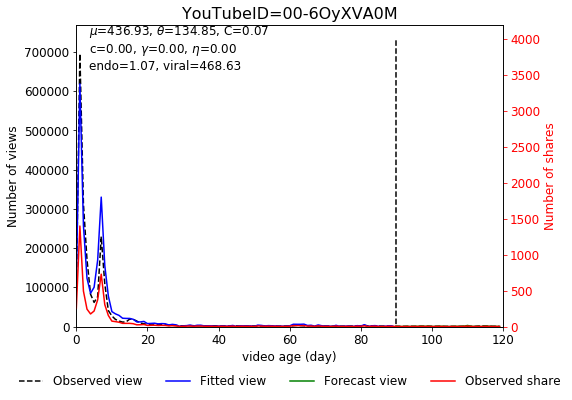

In [8]:
hip_model = HIP()
hip_model.initial(daily_share, daily_view, num_train, num_test, num_initialization)
hip_model.fit_with_bfgs()
hip_model.print_parameters()
hip_model.plot_func('YouTubeID={0}'.format(test_vid))

## Reproduce visualizations in paper

In [9]:
# shares: Popularity scale at 60 days
days = 60
shares = {}
for sample in dataset:
    counts = 0 
    for day in range(days):
        counts += sample["numShare"][day]
    shares[sample["YoutubeID"]] = counts
pd_shares = pd.DataFrame.from_dict(shares, orient="index", columns=("share_day{}".format(days),))
pd_shares.head()

,share_day60
00-6OyXVA0M,5025
00ATf2HR-FA,190
00bumpN0Mhw,4531
00f0ct78HcU,67
00g2ZbI3ung,82


In [10]:
pd_shares.sort_values(by=["share_day60"], inplace=True)
display(pd_shares.head(10))
pd_shares.tail(10)

,share_day60
XhTrsy3DBxU,0
WXv-U0JNApc,0
cEija9njOyo,0
2fkJOAfD9M0,0
7mgjRO9v7Yg,0
-i7ZM-aeDzo,0
K878L-IlYMQ,0
_Beh7wJcIGY,1
3rfPwnJ9iE4,1
WKDE0KCDkvI,1


,share_day60
0HDdjwpPM3Y,95119
7RMQksXpQSk,107896
1Nr_tqkMsJs,113597
b8I-7Wk_Vbc,127461
9G7HxYcwE3g,129473
8Gv0H-vPoDc,146939
VPRjCeoBqrI,176699
6eh5ee491xA,231022
YoB8t0B4jx4,271455
8iPcqtHoR3U,443212


In [11]:
bin_width = len(pd_shares) // 40
pop_scales = []
for i in range(40):
    if i!=40-1:
        log_vals = [math.log(x, 10) if x>=10 else -1 for x in pd_shares["share_day{}".format(days)].
                           iloc[bin_width*i:bin_width*i+bin_width]]
    else:
        log_vals = [math.log(x, 10) if x>=10 else -1 for x in pd_shares["share_day{}".format(days)].
                   iloc[bin_width*i:-1]]
    pop_scales.append(list(filter(lambda x: x!=-1,log_vals)))

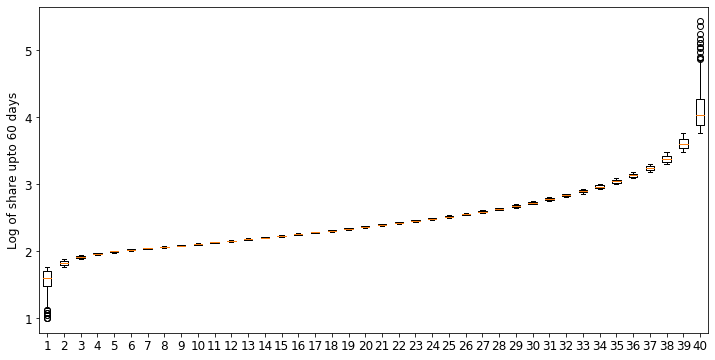

In [12]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.boxplot(pop_scales)
ax1.set_ylabel("Log of share upto {} days".format(days))
# yticklabels = ["10e{}".format(y.get_text()) for y in ax1.get_yticklabels()]
# ax1.set_yticklabels(yticklabels)
pass

In [13]:
def plot_pop_percentile(pop_att, days, dataset):
    shares = {}
    for sample in dataset:
        counts = 0 
        for day in range(days):
            counts += sample[pop_att][day]
        shares[sample["YoutubeID"]] = counts
    col_name = "{}_day{}".format(pop_att, days)
    pd_shares = pd.DataFrame.from_dict(shares, orient="index", columns=(col_name,))
    pd_shares.sort_values(by=[col_name], inplace=True)
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(111)
    ax1.boxplot(pop_scales)
    ax1.set_ylabel("Log of share upto {} days".format(days))
    pass